# 基于Bert的QA模型

---


*by 胡梓泽*

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 4.0MB/s 
     |████████████████████████████████| 901kB 19.6MB/s 
     |████████████████████████████████| 3.3MB 27.5MB/s 


In [ ]:
import torch

In [ ]:
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

## 1.先来一个简单的QA

In [ ]:
question = "How many rubber trees does Hubbard own?"
answer_text = "Hubbard is really rich. He not only owns 321 rubber trees, but also owns a river 123 meters long."
# question = "what does Kobe Bean Bryant do?"
# answer_text = "Kobe Bean Bryant was an American professional basketball player. A shooting guard, he spent his entire 20-year career with the Los Angeles Lakers in the National Basketball Association (NBA). Regarded as one of the greatest basketball players of all time, Bryant won five NBA championships, was an 18-time All-Star, a 15-time member of the All-NBA Team, a 12-time member of the All-Defensive Team, the 2008 NBA Most Valuable Player (MVP), and a two-time NBA Finals MVP. Bryant also led the NBA in scoring twice, and ranks fourth in league all-time regular season and postseason scoring. He was posthumously voted into the Naismith Memorial Basketball Hall of Fame in 2020.Born in Philadelphia and partly raised in Italy, Bryant was recognized as the top American high-school basketball player while at Lower Merion. The son of former NBA player Joe Bryant, he declared for the 1996 NBA draft and was selected by the Charlotte Hornets with the 13th overall pick; he was then traded to the Lakers. As a rookie, Bryant earned a reputation as a high-flyer by winning the 1997 Slam Dunk Contest, and was named an All-Star by his second season. Despite a feud with teammate Shaquille O'Neal, the pair led the Lakers to three consecutive NBA championships from 2000 to 2002."


对于 question 和 answer_text运行BERT tokenizer。返回BERT的输入，我们实际上将它们连接在一起，并在中间放置特殊的[SEP]标记。


In [ ]:
input_ids = tokenizer.encode(question, answer_text)

print('The input has a total of {:} tokens.'.format(len(input_ids)))

The input has a total of 33 tokens.


为了准确地查看标记器(tokenizer)在做什么，让我们打印出带有id的标记。

In [ ]:
# BERT只需要token的IDs, BERT只需要tokens 的id，
#但是为了检查token生成器的行为，让我们也获取token的字符串并显示它们。
tokens = tokenizer.convert_ids_to_tokens(input_ids)

for token, id in zip(tokens, input_ids):
    
    # 如果这是[SEP]标记，在其周围添加一些空格，使其突出。
    if id == tokenizer.sep_token_id:
        print('')
    
    # 在两列中打token字符串及其ID
    print('{:<12} {:>6,}'.format(token, id))

    if id == tokenizer.sep_token_id:
        print('')
    

[CLS]           101
how           2,129
many          2,116
rubber        8,903
trees         3,628
does          2,515
hubbard      16,580
own           2,219
?             1,029

[SEP]           102

hubbard      16,580
is            2,003
really        2,428
rich          4,138
.             1,012
he            2,002
not           2,025
only          2,069
owns          8,617
321          24,030
rubber        8,903
trees         3,628
,             1,010
but           2,021
also          2,036
owns          8,617
a             1,037
river         2,314
123          13,138
meters        5,563
long          2,146
.             1,012

[SEP]           102



我们拼接question 和 answer_text在一起，但BERT仍然需要一种方法来区分它们。bert有两个特殊的"Segment" 嵌入。一个是A，一个是B。在单词嵌入进入BERT层之前，段A嵌入需要添加到question标记中，段B嵌入需要添加到每个answer_text标记中。

这些添加的内容由transformers 库为我们处理，我们所需要做的就是为每个令牌指定一个’0’或’1’。

In [ ]:
# 在input_ids中搜索`[SEP]`标记的第一个实例。
sep_index = input_ids.index(tokenizer.sep_token_id) # 在sep出现的位置

# 段A标记的数量包括[SEP]标记本身。
num_seg_a = sep_index + 1 # sep后面的位置

# 剩余的是B
num_seg_b = len(input_ids) - num_seg_a

# 构造0和1的列表。
segment_ids = [0]*num_seg_a + [1]*num_seg_b

# 每个输入令牌都应该有一个segment_id。
assert len(segment_ids) == len(input_ids)

我们已经准备好将示例输入模型了!
注意:结果对象的类型是QuestionAnsweringModelOutput



In [ ]:
# 在模型中运行我们的示例。
outputs = model(torch.tensor([input_ids]), # 表示输入文本的标记。
                             token_type_ids=torch.tensor([segment_ids]), # 用于区分question和answer_text的段id
                             return_dict=True) 

start_scores = outputs.start_logits
end_scores = outputs.end_logits


现在我们可以通过查看最有可能的开始词和结束词来突出答案。



In [ ]:
# 找到“开始”和“结束”分数最高的标记。
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# 将答案中的标记组合起来并打印出来。
answer = ' '.join(tokens[answer_start:answer_end+1])

print('Answer: "' + answer + '"')

Answer: "321"


重建被分解成子词的任何单词



In [ ]:
# Start with the first token.
answer = tokens[answer_start]

# Select the remaining answer tokens and join them with whitespace.
for i in range(answer_start + 1, answer_end + 1):
    
    # If it's a subword token, then recombine it with the previous token.
    if tokens[i][0:2] == '##':
        answer += tokens[i][2:]
    
    # Otherwise, add a space then the token.
    else:
        answer += ' ' + tokens[i]

print('Answer: "' + answer + '"')

Answer: "321"





## 2.可视化单词分数

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# 增加plot大小和字体大小。
#sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,8)

检索所有的开始和结束分数，并使用所有标记作为x轴标签。

In [ ]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))


### 2.1创建一个条形图，显示每个输入单词作为“start”单词的得分。

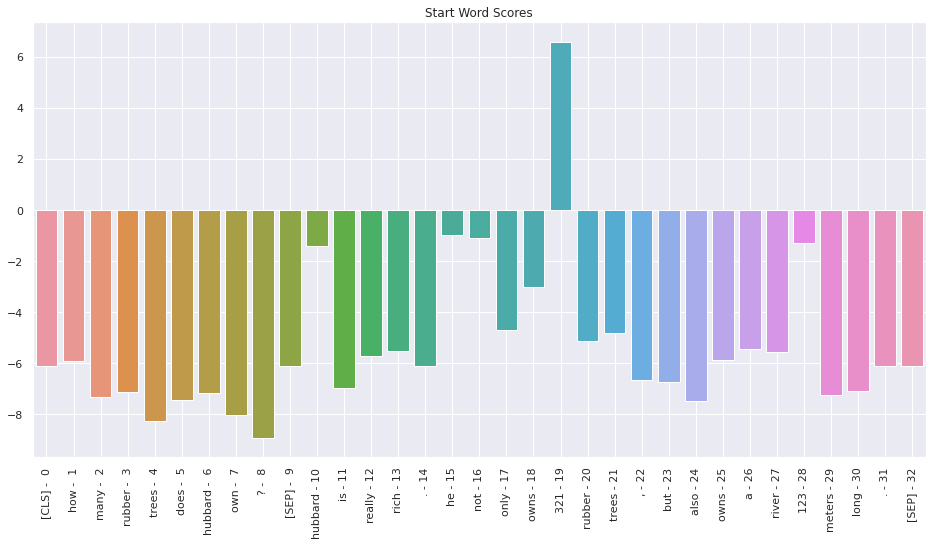

In [ ]:
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

### 2.2创建第二个条形图，显示作为“end”单词的每个输入单词的得分。

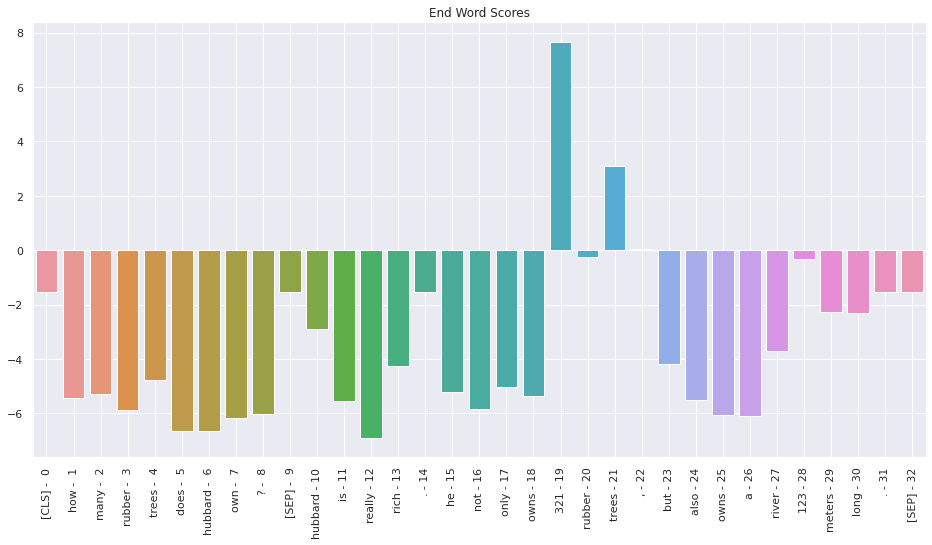

In [ ]:
# Create a barplot showing the end word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('End Word Scores')

plt.show()

### 2.3合并start和end

In [ ]:
import pandas as pd

# Store the tokens and scores in a DataFrame. 
# Each token will have two rows, one for its start score and one for its end
# score. The "marker" column will differentiate them. A little wacky, I know.
scores = []
for (i, token_label) in enumerate(token_labels):

    # Add the token's start score as one row.
    scores.append({'token_label': token_label, 
                   'score': s_scores[i],
                   'marker': 'start'})
    
    # Add  the token's end score as another row.
    scores.append({'token_label': token_label, 
                   'score': e_scores[i],
                   'marker': 'end'})
    
df = pd.DataFrame(scores)


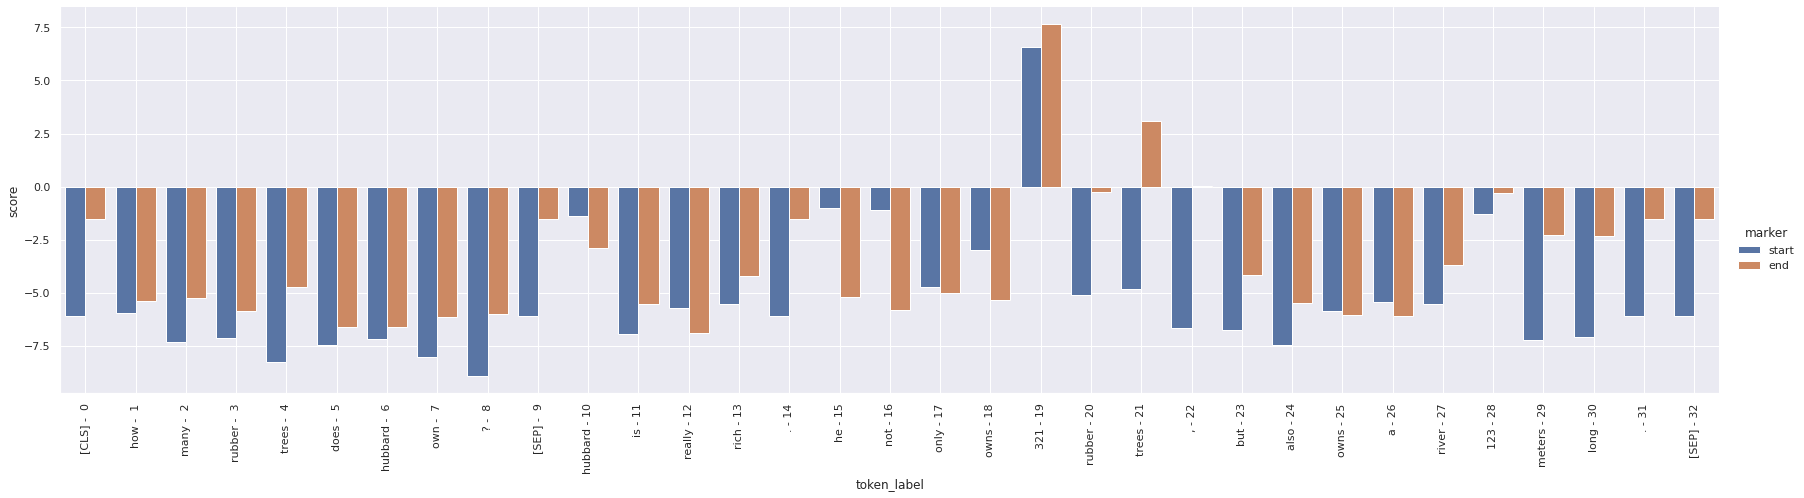

In [ ]:
# Draw a grouped barplot to show start and end scores for each word.
# The "hue" parameter is where we tell it which datapoints belong to which
# of the two series.
g = sns.catplot(x="token_label", y="score", hue="marker", data=df,
                kind="bar", height=6, aspect=4)

# Turn the xlabels vertical.
g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
g.ax.grid(True)


### 2.4汇总画图模型

In [ ]:
def show_score(input_ids):
  import matplotlib.pyplot as plt
  import seaborn as sns

  # Use plot styling from seaborn.
  sns.set(style='darkgrid')

  # 增加plot大小和字体大小。
  #sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (16,8)
  # 在input_ids中搜索`[SEP]`标记的第一个实例。
  sep_index = input_ids.index(tokenizer.sep_token_id) # 在sep出现的位置

  # 段A标记的数量包括[SEP]标记本身。
  num_seg_a = sep_index + 1 # sep后面的位置

  # 剩余的是B
  num_seg_b = len(input_ids) - num_seg_a

  # 构造0和1的列表。
  segment_ids = [0]*num_seg_a + [1]*num_seg_b

  # 每个输入令牌都应该有一个segment_id。
  assert len(segment_ids) == len(input_ids)
  # 在模型中运行我们的示例。
  outputs = model(torch.tensor([input_ids]), # 表示输入文本的标记。
                              token_type_ids=torch.tensor([segment_ids]), # 用于区分question和answer_text的段id
                              return_dict=True) 

  start_scores = outputs.start_logits
  end_scores = outputs.end_logits

  # Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
  s_scores = start_scores.detach().numpy().flatten()
  e_scores = end_scores.detach().numpy().flatten()

  # BERT只需要token的IDs, BERT只需要tokens 的id，
  #但是为了检查token生成器的行为，让我们也获取token的字符串并显示它们。
  tokens = tokenizer.convert_ids_to_tokens(input_ids)

  # We'll use the tokens as the x-axis labels. In order to do that, they all need
  # to be unique, so we'll add the token index to the end of each one.
  token_labels = []
  for (i, token) in enumerate(tokens):
      token_labels.append('{:} - {:>2}'.format(token, i))
#------------------------------------------------------------------------------------------------------------------------------------------------------------
  # Create a barplot showing the start word score for all of the tokens.
  ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

  # Turn the xlabels vertical.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

  # Turn on the vertical grid to help align words to scores.
  ax.grid(True)

  plt.title('Start Word Scores')

  plt.show()
#------------------------------------------------------------------------------------------------------------------------------------------------------------
  # Create a barplot showing the end word score for all of the tokens.
  ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

  # Turn the xlabels vertical.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

  # Turn on the vertical grid to help align words to scores.
  ax.grid(True)

  plt.title('End Word Scores')

  plt.show()
#------------------------------------------------------------------------------------------------------------------------------------------------------------
  import pandas as pd

  # Store the tokens and scores in a DataFrame. 
  # Each token will have two rows, one for its start score and one for its end
  # score. The "marker" column will differentiate them. A little wacky, I know.
  scores = []
  for (i, token_label) in enumerate(token_labels):

      # Add the token's start score as one row.
      scores.append({'token_label': token_label, 
                    'score': s_scores[i],
                    'marker': 'start'})
      
      # Add  the token's end score as another row.
      scores.append({'token_label': token_label, 
                    'score': e_scores[i],
                    'marker': 'end'})
      
  df = pd.DataFrame(scores)
  # Draw a grouped barplot to show start and end scores for each word.
  # The "hue" parameter is where we tell it which datapoints belong to which
  # of the two series.
  g = sns.catplot(x="token_label", y="score", hue="marker", data=df,
                  kind="bar", height=6, aspect=4)

  # Turn the xlabels vertical.
  g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")

  # Turn on the vertical grid to help align words to scores.
  g.ax.grid(True)

## 3.汇总QA模型

将QA过程转换为一个函数，以便我们可以轻松地尝试其他示例。

In [ ]:
def answer_question(question, answer_text):
    '''
    设定`question`和`answer_text`(包含答案)字符串，定义单词的答案
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input_ids = tokenizer.encode(question, answer_text)
    show_score(input_ids)
    # Report how long the input sequence is.
    print('Query has {:,} tokens.\n'.format(len(input_ids)))

    # ======== Set Segment IDs ========
    # Search the input_ids for the first instance of the `[SEP]` token.
    sep_index = input_ids.index(tokenizer.sep_token_id)

    # The number of segment A tokens includes the [SEP] token istelf.
    num_seg_a = sep_index + 1

    # The remainder are segment B.
    num_seg_b = len(input_ids) - num_seg_a

    # Construct the list of 0s and 1s.
    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    # There should be a segment_id for every input token.
    assert len(segment_ids) == len(input_ids)

    # ======== Evaluate ========
    # Run our example through the model.
    outputs = model(torch.tensor([input_ids]), # The tokens representing our input text.
                    token_type_ids=torch.tensor([segment_ids]), # The segment IDs to differentiate question from answer_text
                    return_dict=True) 

    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]

    print('Answer: "' + answer + '"')

As our reference text, I've taken the Abstract of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf).


In [ ]:
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 
bert_abstract = "Kobe Bean Bryant was an American professional basketball player. A shooting guard, he spent his entire 20-year career with the Los Angeles Lakers in the National Basketball Association (NBA). Regarded as one of the greatest basketball players of all time, Bryant won five NBA championships, was an 18-time All-Star, a 15-time member of the All-NBA Team, a 12-time member of the All-Defensive Team, the 2008 NBA Most Valuable Player (MVP), and a two-time NBA Finals MVP. Bryant also led the NBA in scoring twice, and ranks fourth in league all-time regular season and postseason scoring. He was posthumously voted into the Naismith Memorial Basketball Hall of Fame in 2020.Born in Philadelphia and partly raised in Italy, Bryant was recognized as the top American high-school basketball player while at Lower Merion. The son of former NBA player Joe Bryant, he declared for the 1996 NBA draft and was selected by the Charlotte Hornets with the 13th overall pick; he was then traded to the Lakers. As a rookie, Bryant earned a reputation as a high-flyer by winning the 1997 Slam Dunk Contest, and was named an All-Star by his second season. Despite a feud with teammate Shaquille O'Neal, the pair led the Lakers to three consecutive NBA championships from 2000 to 2002."
print(wrapper.fill(bert_abstract))

Kobe Bean Bryant was an American professional basketball player. A shooting
guard, he spent his entire 20-year career with the Los Angeles Lakers in the
National Basketball Association (NBA). Regarded as one of the greatest
basketball players of all time, Bryant won five NBA championships, was an
18-time All-Star, a 15-time member of the All-NBA Team, a 12-time member of the
All-Defensive Team, the 2008 NBA Most Valuable Player (MVP), and a two-time NBA
Finals MVP. Bryant also led the NBA in scoring twice, and ranks fourth in league
all-time regular season and postseason scoring. He was posthumously voted into
the Naismith Memorial Basketball Hall of Fame in 2020.Born in Philadelphia and
partly raised in Italy, Bryant was recognized as the top American high-school
basketball player while at Lower Merion. The son of former NBA player Joe
Bryant, he declared for the 1996 NBA draft and was selected by the Charlotte
Hornets with the 13th overall pick; he was then traded to the Lakers. As a

-----------------------------
### 3.1测试几个简单小例子

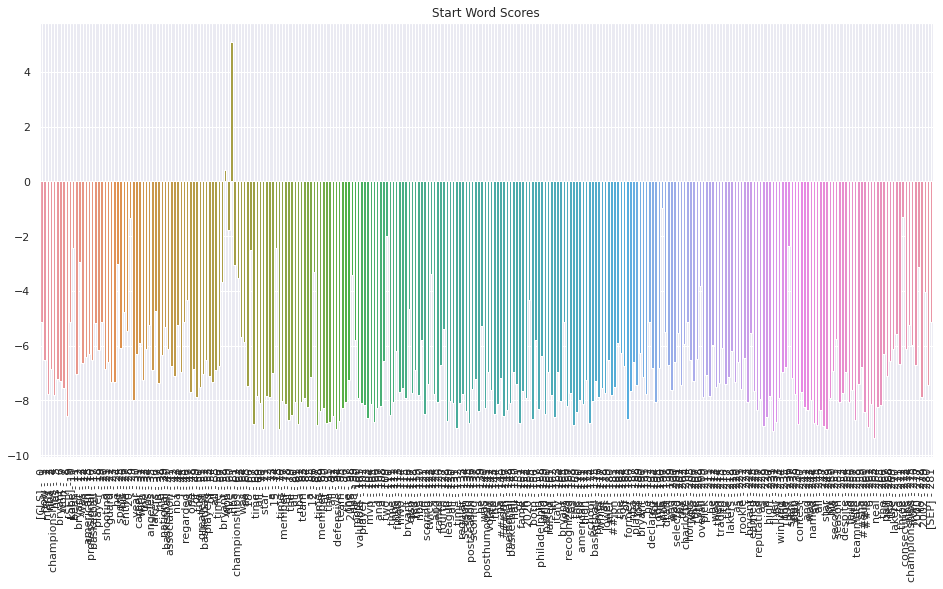

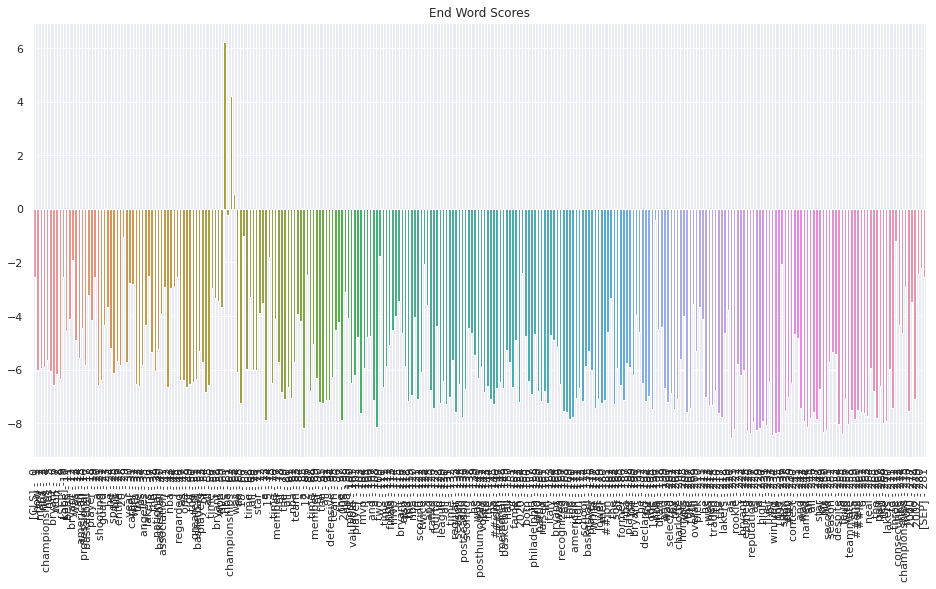

Query has 282 tokens.

Answer: "five"


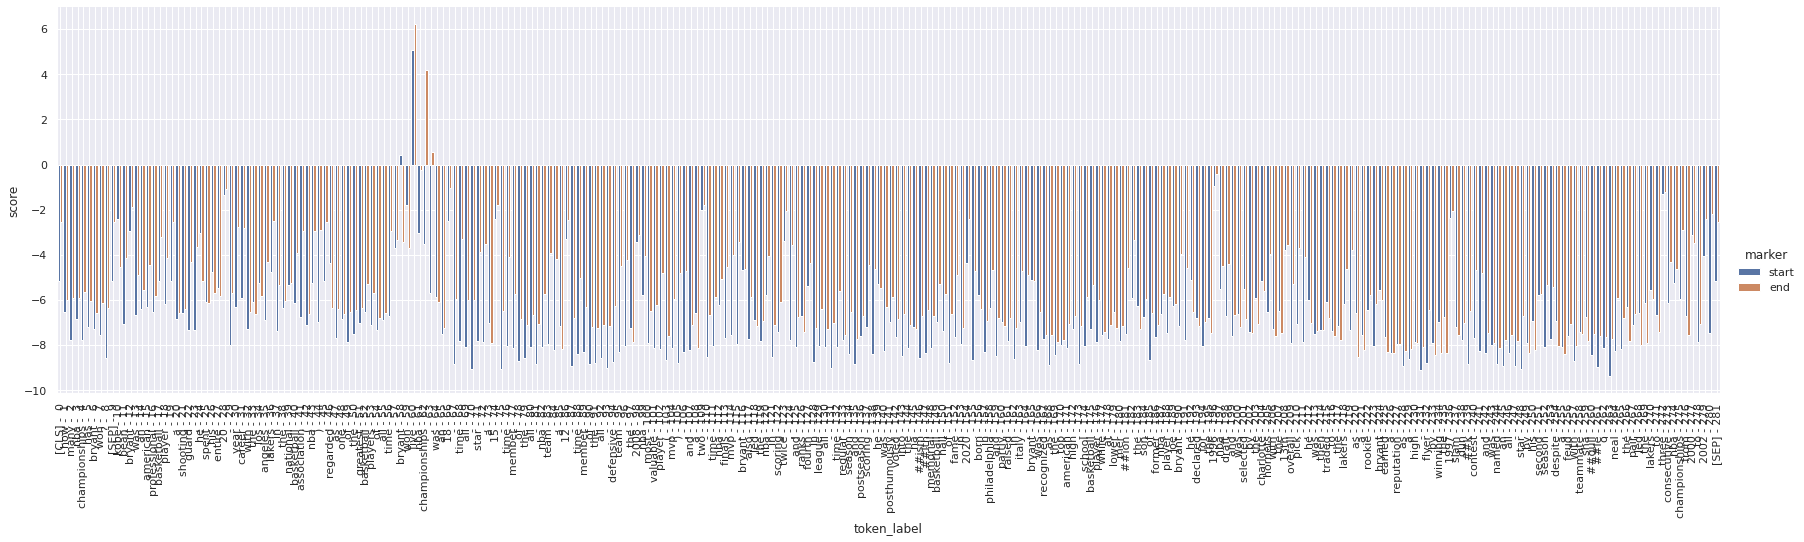

In [ ]:
question = "How many NBA championships has Bryant won?"
answer_text = "Kobe Bean Bryant was an American professional basketball player. A shooting guard, he spent his entire 20-year career with the Los Angeles Lakers in the National Basketball Association (NBA). Regarded as one of the greatest basketball players of all time, Bryant won five NBA championships, was an 18-time All-Star, a 15-time member of the All-NBA Team, a 12-time member of the All-Defensive Team, the 2008 NBA Most Valuable Player (MVP), and a two-time NBA Finals MVP. Bryant also led the NBA in scoring twice, and ranks fourth in league all-time regular season and postseason scoring. He was posthumously voted into the Naismith Memorial Basketball Hall of Fame in 2020.Born in Philadelphia and partly raised in Italy, Bryant was recognized as the top American high-school basketball player while at Lower Merion. The son of former NBA player Joe Bryant, he declared for the 1996 NBA draft and was selected by the Charlotte Hornets with the 13th overall pick; he was then traded to the Lakers. As a rookie, Bryant earned a reputation as a high-flyer by winning the 1997 Slam Dunk Contest, and was named an All-Star by his second season. Despite a feud with teammate Shaquille O'Neal, the pair led the Lakers to three consecutive NBA championships from 2000 to 2002."
answer_question(question, answer_text)

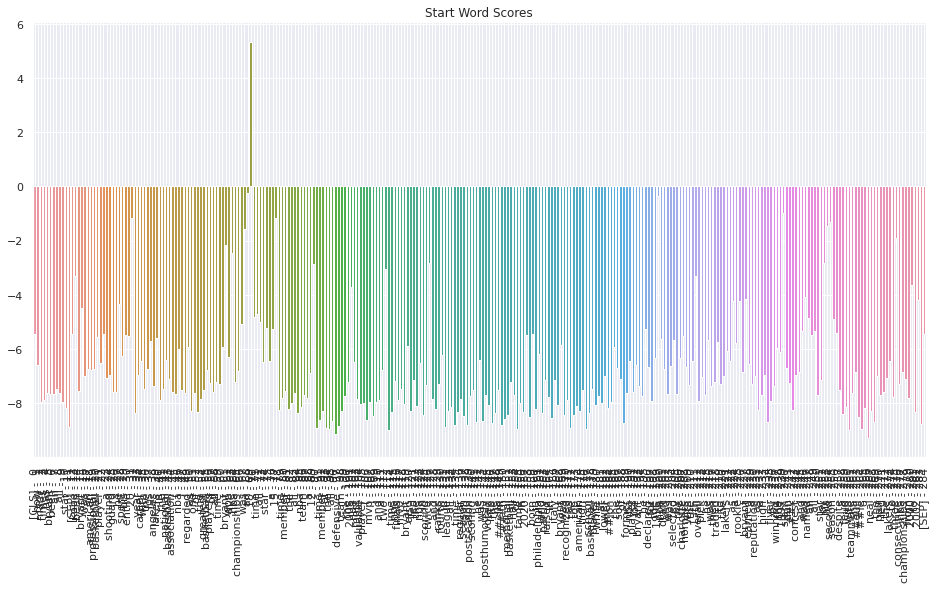

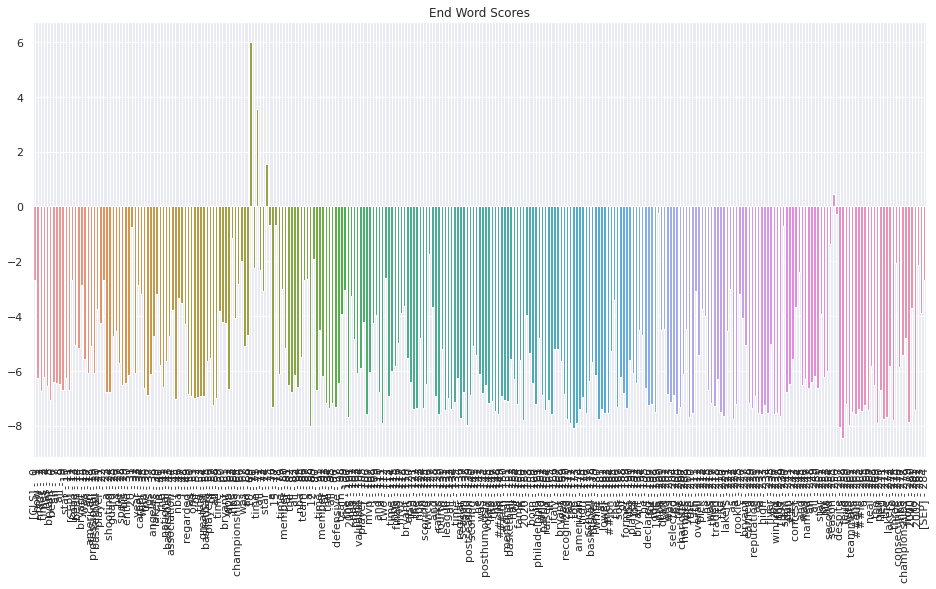

Query has 285 tokens.

Answer: "18"


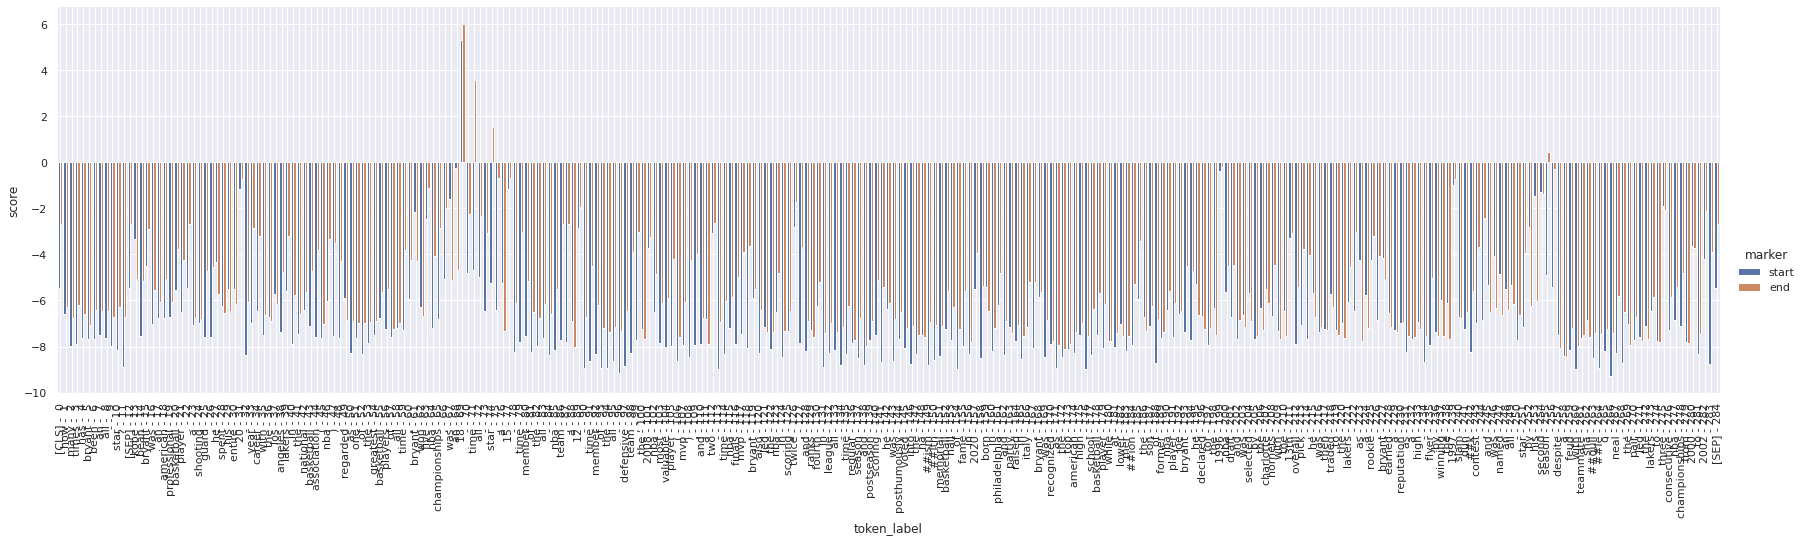

In [ ]:
question = "How many times has Bryant been an All-Star?"
answer_question(question, bert_abstract)

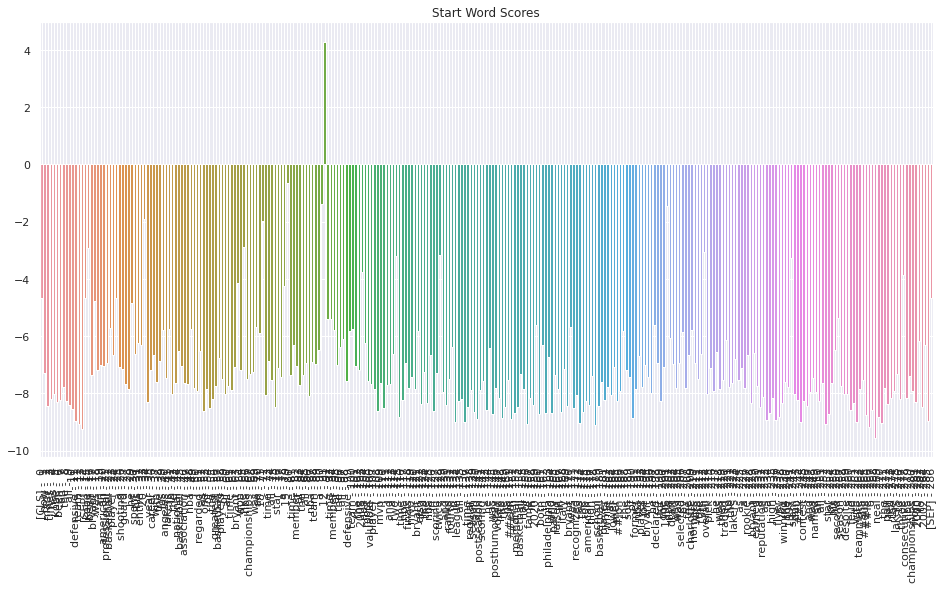

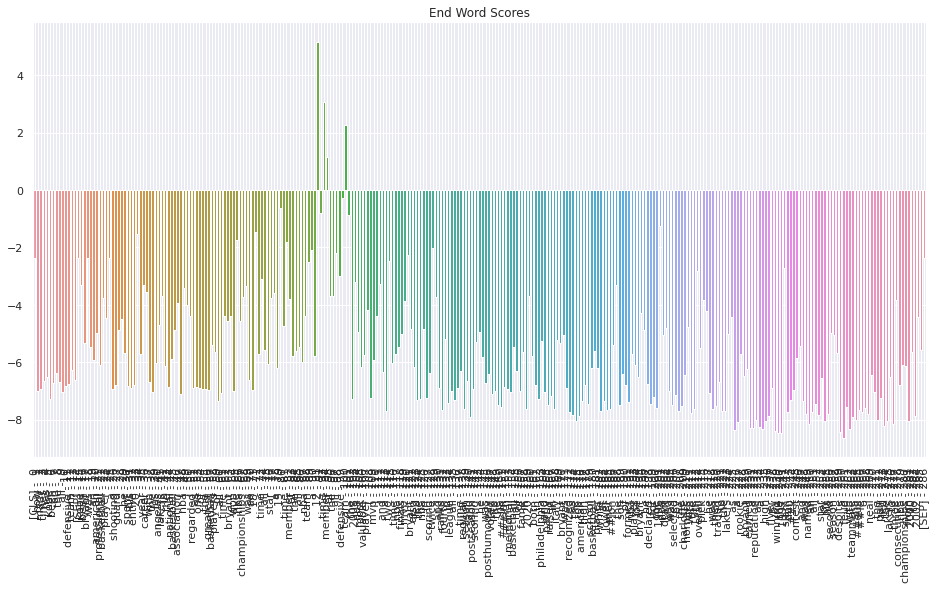

Query has 287 tokens.

Answer: "12"


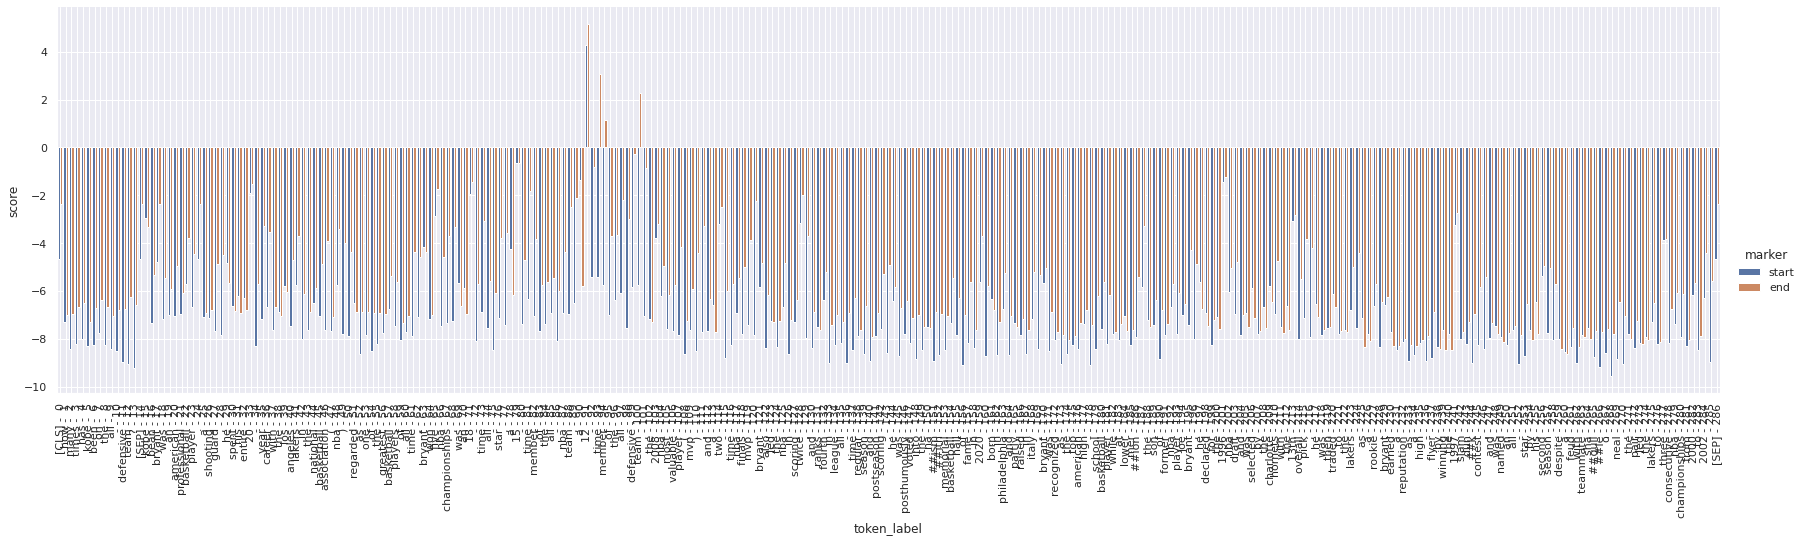

In [ ]:
question = "How many times has kobe been on the all-defensive team?"
answer_question(question, bert_abstract)

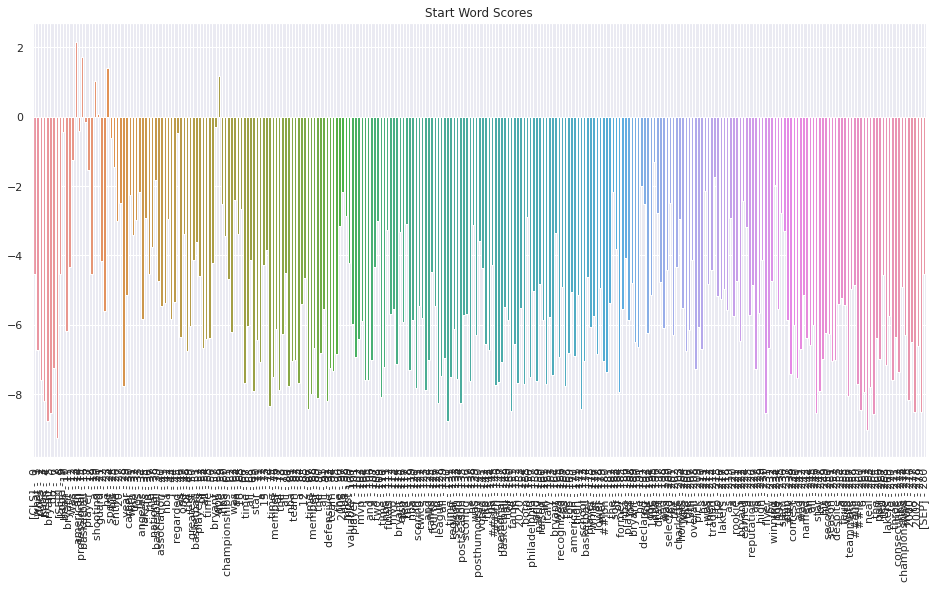

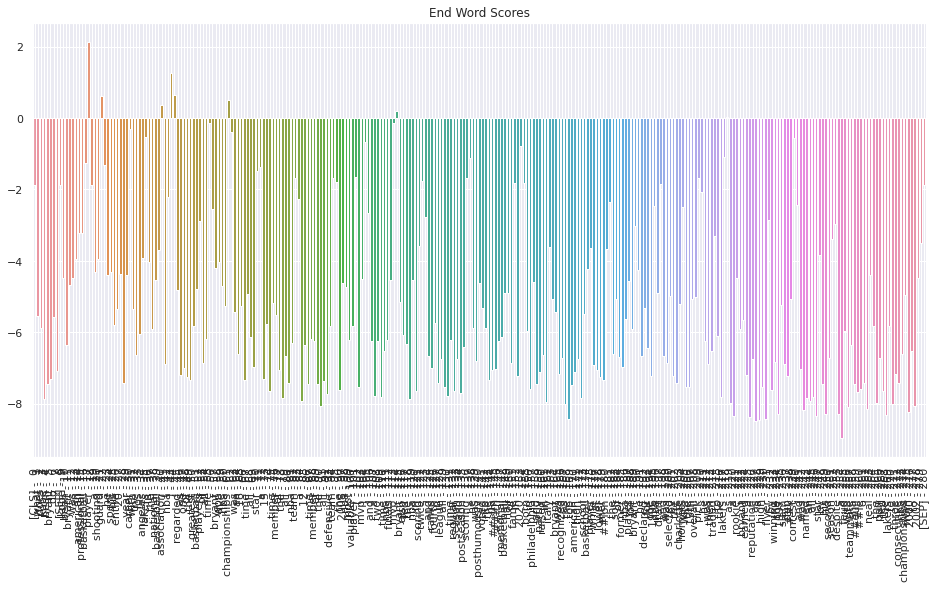

Query has 281 tokens.

Answer: "an american professional basketball player"


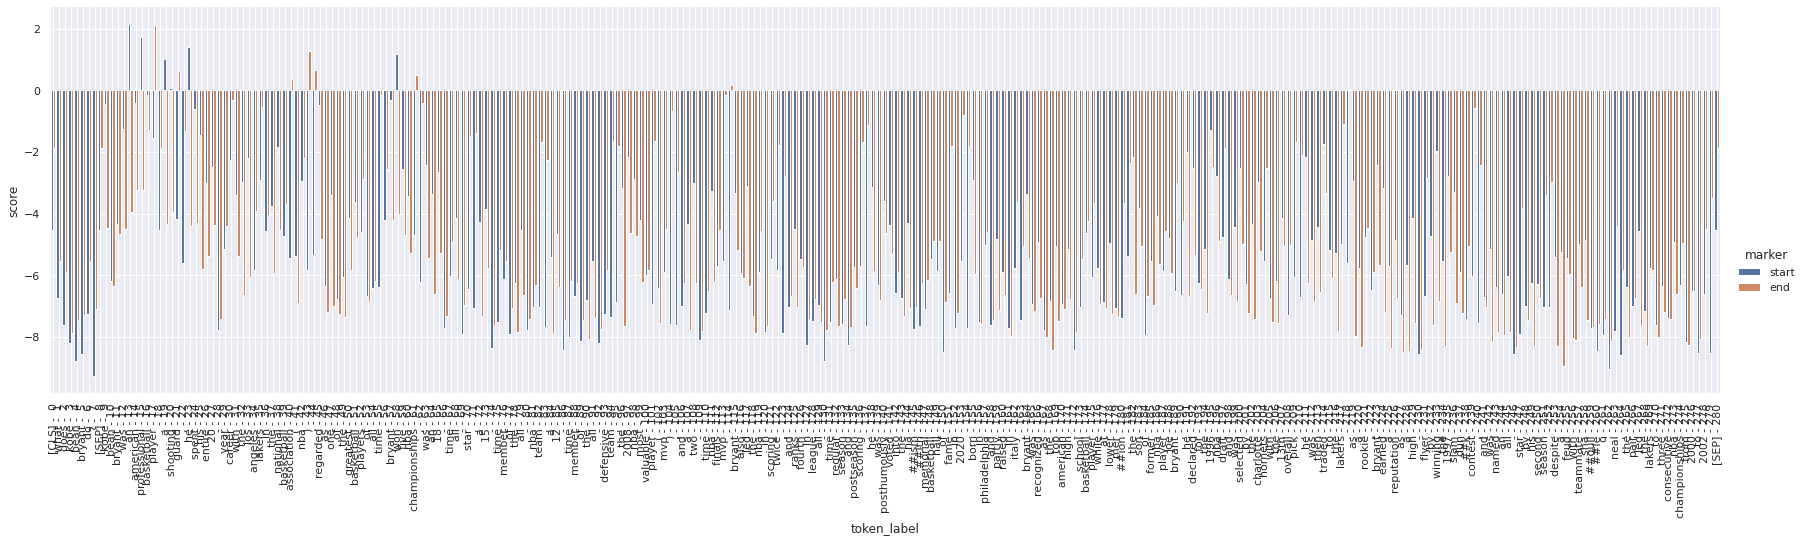

In [ ]:
question = "what does Kobe Bean Bryant do?"
answer_question(question, bert_abstract)

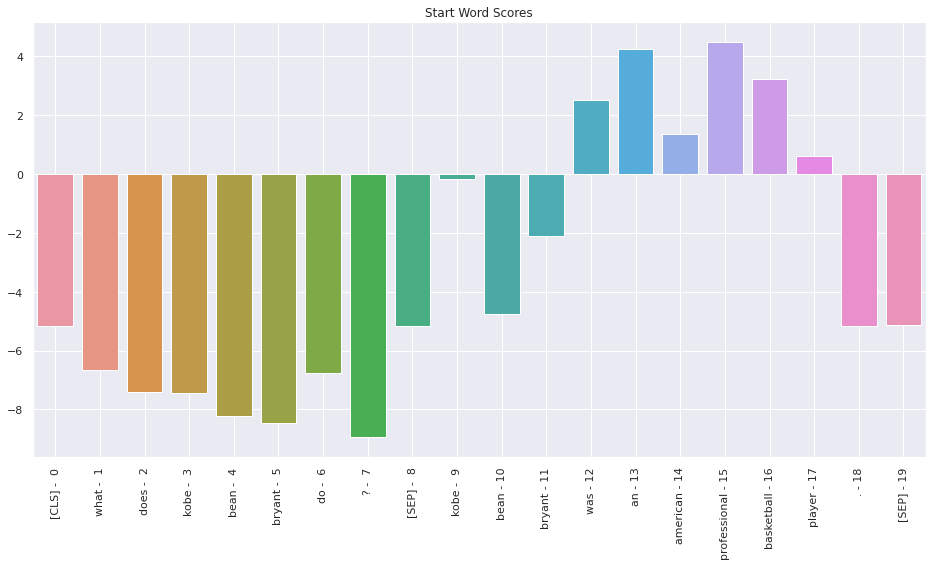

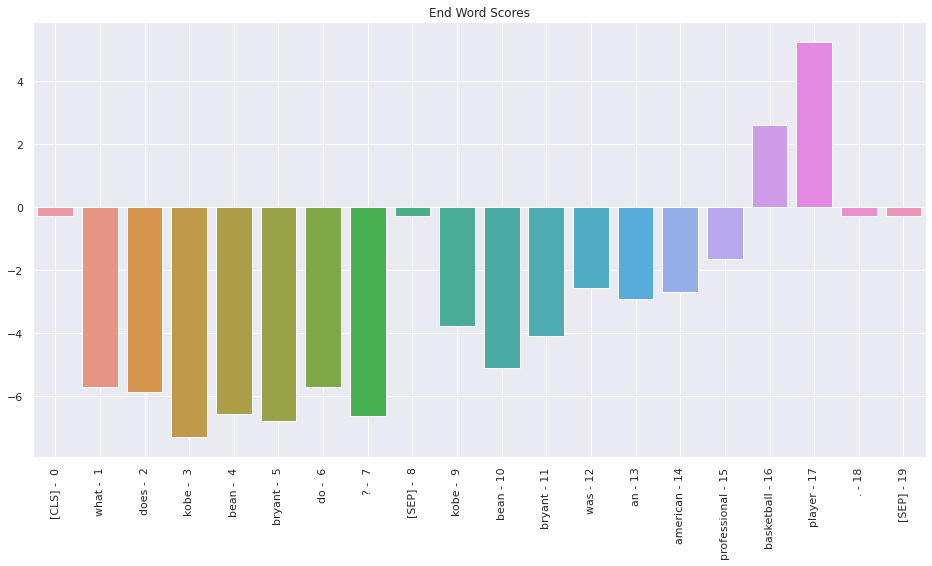

Query has 20 tokens.

Answer: "professional basketball player"


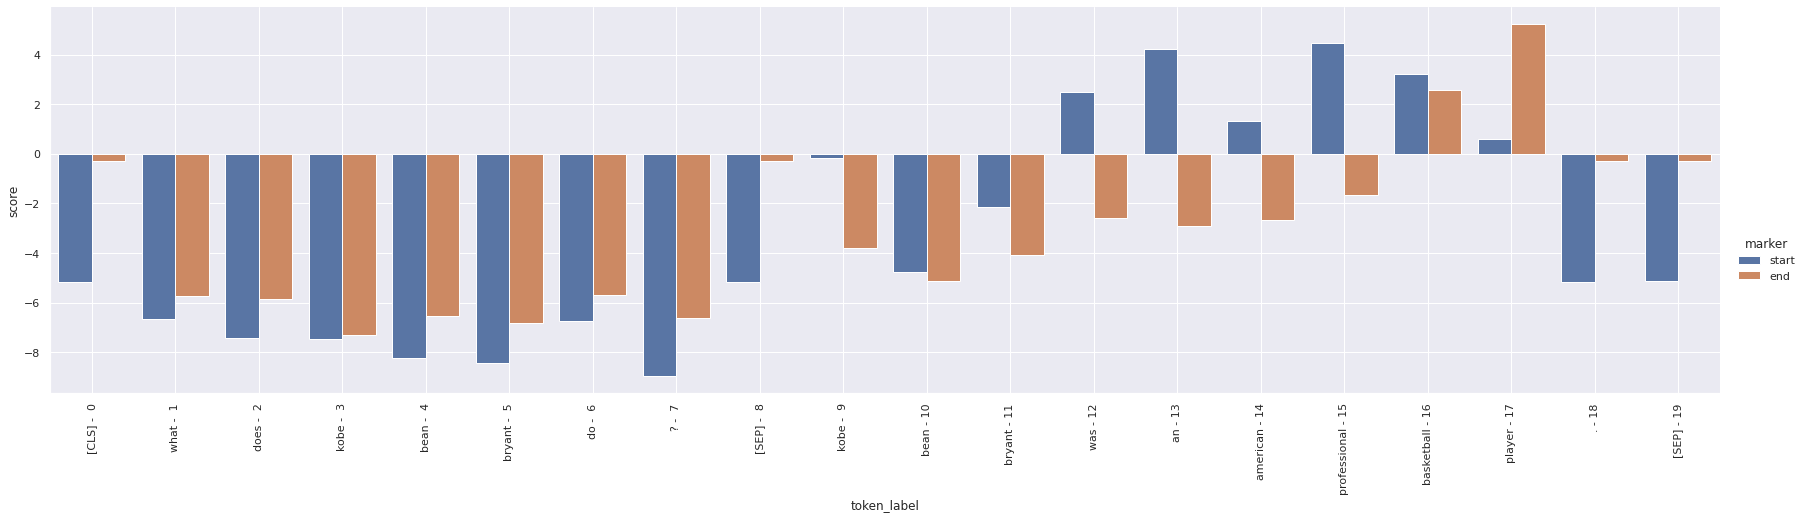

In [ ]:
question = "what does Kobe Bean Bryant do?"
answer_text = "Kobe Bean Bryant was an American professional basketball player."
answer_question(question, answer_text)